#### Import and ENV

In [2]:
import torch.nn as nn
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from torchmetrics import Accuracy

In [3]:
##A2 Dataset##########################################################
# Setup working directory
######################################################################
%mkdir -p /content/csc413/DLProject/
%cd /content/csc413/DLProject

/content/csc413/DLProject


In [4]:
!git clone -b local_ver https://github.com/AlisaYang07/DL-AutoEncoder.git

Cloning into 'DL-AutoEncoder'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 36 (delta 0), reused 3 (delta 0), pack-reused 30
Unpacking objects: 100% (36/36), 208.55 MiB | 6.88 MiB/s, done.


In [5]:
%cd /content/csc413/DLProject/DL-AutoEncoder

/content/csc413/DLProject/DL-AutoEncoder


In [6]:
# from google.colab import drive
# drive.mountn("/content/drive")
# data_pt= "/content/drive/My Drive/"
# dtata 


## **DataLoader**

https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/cifar10-baseline.html

In [7]:
from data import *
train_ds, val_ds, test_ds = get_datasets()
dataloader_train = dataset_to_dataloader(train_ds)
dataloader_test = dataset_to_dataloader(test_ds)
dataloader_val = dataset_to_dataloader(val_ds)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


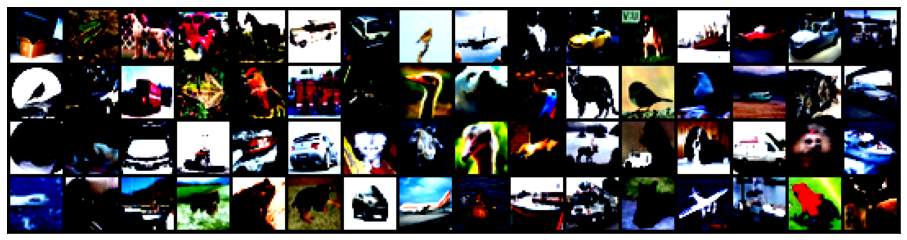

In [8]:
test_dataloader(dataloader_train)

## **AutoEncoder Model**

In [50]:
from encoder import *
from decoder import *

### Some Initial Test

In [51]:
# # Pretrained model
# my_model = resnet18(pretrained=True)


In [52]:
# if torch.cuda.is_available():
#   my_model.to(torch.device('cuda:0'))

In [53]:
# def evaluate(model, dataloader):
#         """Compute the Accuracy of the test set
#         * Model (RestNet18 Module)
#         * Dataload
#         *Iterates through the DataLoader to calculate the  

#         """
#         val_acc = []
#         for X_batch, y_batch in dataloader:
#           if torch.cuda.is_available():
#             X_batch = X_batch.cuda()
#             y_pred = model(X_batch)
#             X_batch = X_batch.cpu()
#             y_pred = y_pred.cpu()
#           else: 
#             y_pred = model(X_batch)

#           y_pred_softmax = torch.softmax(y_pred, dim=0)
#           y_pred_arg_max = torch.argmax(y_pred_softmax, dim=1)

#           accuracy = Accuracy(task="multiclass", num_classes=10)
#           acc = accuracy(y_pred_arg_max,y_batch)
#           val_acc.append(acc)
#           # print("Model accuracy: %.2f%%" % (acc*100))
#         val_acc = np.array(val_acc)
#         avg_val_acc = np.mean(val_acc) 
#         print("Avg. Model accuracy: %.2f%%" % (avg_val_acc*100))

#         return avg_val_acc


In [54]:
# evaluate(my_model, dataloader_val)

In [55]:
# my_model.cpu()

## **Training** 

In [56]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder 
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoder = self.decoder(encoded)
        return decoder


In [57]:
# from encoder import *
import torch
import torch.nn as nn
from torchmetrics import Accuracy

import numpy as np

__all__ = [
    "ResNet",
    "resnet18",
]

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group

        # CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False
        )
        # END

        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, device, num_classes, **kwargs):
    model = ResNet(block, layers, num_classes,**kwargs)
    if pretrained:
        script_dir = '.'
        state_dict = torch.load(
            script_dir + "/" + arch + ".pt", map_location=device
        )
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, device="cpu",num_classes=10, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, device, num_classes, **kwargs
    )

def _classification_eval(model, dataloader):
    """Compute the Accuracy of the test set
    * Model (RestNet18 Module)
    * Dataload
    *Iterates through the DataLoader to calculate the  

    """
    val_acc = []
    for X_batch, y_batch in dataloader:
        if torch.cuda.is_available():
            X_batch = X_batch.cuda()
            y_pred = model(X_batch)
            X_batch = X_batch.cpu()
            y_pred = y_pred.cpu()
        else: 
            y_pred = model(X_batch)

        y_pred_softmax = torch.softmax(y_pred, dim=0)
        y_pred_arg_max = torch.argmax(y_pred_softmax, dim=1)

        accuracy = Accuracy(task="multiclass", num_classes=10)
        acc = accuracy(y_pred_arg_max,y_batch)
        val_acc.append(acc)
        # print("Model accuracy: %.2f%%" % (acc*100))
    val_acc = np.array(val_acc)
    avg_val_acc = np.mean(val_acc) 
    print("Avg. Model accuracy: %.2f%%" % (avg_val_acc*100))

    return avg_val_acc



In [58]:
# from decoder import *
import torch
import torch.nn.functional as F
import torch.nn as nn

class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.ConvTranspose2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)

        if stride == 1:
            self.conv1 = nn.ConvTranspose2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out



class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=1)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = self.conv1(x)
        #x = x.view(x.size(0), 3, 32, 32)
        return x


In [59]:
from training import *

In [60]:
bottle_neck = 32
encoder = resnet18(pretrained=False,num_classes=bottle_neck)
decoder = ResNet18Dec(z_dim=bottle_neck)
model = AutoEncoder(encoder=encoder, decoder= decoder).to(torch.device('cuda:0'))

In [61]:

# model = resnet18(pretrained=False).to(torch.device('cuda:0'))
# criterion =  nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
model, history = train(
    model,
    criterion,
    optimizer,
    dataloader_train,
    dataloader_val,
    save_file_name='auto-encoder-40.pt',
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Starting Training from Scratch.


Epoch: 1 	Training Loss: 0.3172 	Validation Loss: 48.6088

Epoch: 3 	Training Loss: 0.2551 	Validation Loss: 0.2449

Epoch: 5 	Training Loss: 0.2238 	Validation Loss: 0.2793

Epoch: 7 	Training Loss: 0.2387 	Validation Loss: 0.2296

Epoch: 9 	Training Loss: 0.2042 	Validation Loss: 0.2126

Epoch: 11 	Training Loss: 0.1985 	Validation Loss: 0.4563

Epoch: 13 	Training Loss: 0.1928 	Validation Loss: 0.2086

Early Stopping! Total epochs: 13. Best epoch: 8 with loss: 0.20
1337.13 total seconds elapsed. 95.51 seconds per epoch.


In [62]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        with torch.no_grad():
          for t, m, s in zip(tensor, self.mean, self.std):
              t.mul_(s).add_(m)
              # The normalize code -> t.sub_(m).div_(s)
          return tensor

In [63]:
from torchvision.utils import make_grid
unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))

def peek_results(dataloader, model):
  for img,lb in dataloader:
    fig, ax = plt.subplots(figsize=(16,8))
    fig1, ax1 = plt.subplots(figsize=(16,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax1.set_SSxticks([]); ax1.set_yticks([])
    img_output = model(img.cuda()).cpu()
    ax.imshow(make_grid(unorm(img_output), nrow=16).permute(1,2,0))
    ax1.imshow(make_grid(img, nrow=16).permute(1,2,0))
    break


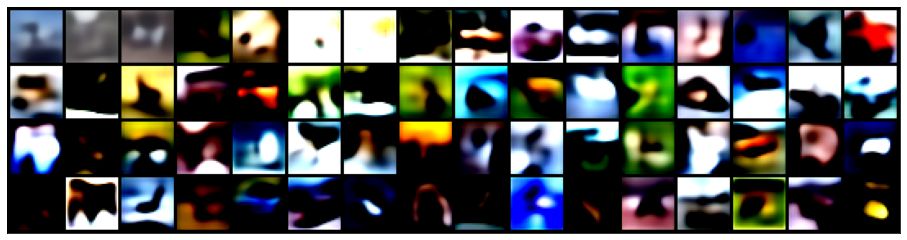

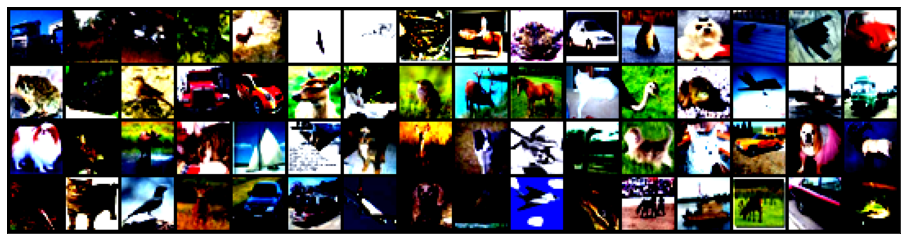

In [64]:
peek_results(dataloader_test, model)

In [65]:
bottle_neck = 64
encoder = resnet18(pretrained=False,num_classes=bottle_neck)
decoder = ResNet18Dec(z_dim=bottle_neck)
model = AutoEncoder(encoder=encoder, decoder= decoder).to(torch.device('cuda:0'))

In [ ]:

# model = resnet18(pretrained=False).to(torch.device('cuda:0'))
# criterion =  nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
model, history = train(
    model,
    criterion,
    optimizer,
    dataloader_train,
    dataloader_val,
    save_file_name='auto-encoder-64.pt',
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Model has been trained for: 0 epochs.



In [ ]:
from torchvision.utils import make_grid

def peek_results(dataloader, model):
  unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))
  for img,lb in dataloader:
    fig, ax = plt.subplots(figsize=(16,8))
    fig1, ax1 = plt.subplots(figsize=(16,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax1.set_SSxticks([]); ax1.set_yticks([])
    img_output = model(img.cuda()).cpu()
    ax.imshow(make_grid(unorm(img_output), nrow=16).permute(1,2,0))
    ax1.imshow(make_grid(img, nrow=16).permute(1,2,0))
    break


In [ ]:
peek_results(dataloader_test, model)